# The search for allopatric speciation in the gut microbial communities of Tanganyikan cichlids

## An adventure in fish poo.

*Russell Neches*

### Gut community structure in fish, and cichlids in particular


Here are some papers that examine the gut microbiome of fish, including
African cichlids.

* [Bacterial community structure in the intestinal ecosystem of rainbow trout (Oncorhynchus mykiss) as revealed by pyrosequencing-based analysis of 16S rRNA genes](http://dx.doi.org/10.1016/j.rvsc.2015.03.026). *Research in veterinary science*, Vol. 100 (June 2015), pp. 8-11 by Miray Etyemez, José Luis L. Balcázar

* [Perturbation and restoration of the fathead minnow gut microbiome after low-level triclosan exposure](http://dx.doi.org/10.1186/s40168-015-0069-6). *Microbiome*, Vol. 3 (2015), by Adrienne B. Narrowe, Munira Albuthi-Lantz, Erin P. Smith, et al.

* [Gut Microbiota Dynamics during Dietary Shift in Eastern African Cichlid Fishes](http://dx.doi.org/10.1371/journal.pone.0127462). *PLoS ONE*, Vol. 10, No. 5. (15 May 2015), e0127462, by Laura Baldo, Joan L. Riera, Ave Tooming-Klunderud, Mar M. Albà, Walter Salzburger


### Build OTU table, sample metadata and host tree

After much frustration, I've decided to abandon [`QIIME`](http://qiime.org/)
in favor of a simpler, more direct approach. I think this approach will be 
more useful to researchers who are pursuing novel statistical and phylogenetic
treatments of community amplicon data. 

I use [`vsearch`](https://github.com/torognes/vsearch) to perform chimera
checking and to cluster the data into OTUs. This step goes a lot faster if
a reference database of full-length 16S genes is used (I suggest the 
[`SILVA SSU Ref`](http://www.arb-silva.de/download/arb-files/) database, 
but it probably doesn't matter very much which one is used). The rest of 
the analysis is reference-free, so there is perhaps an interest in running
the chimera checking step *de novo*.

Then I use [`ssu-align`](http://selab.janelia.org/software/ssu-align/) to build an
alignment of all cluster centroids. Those who are not targeting an rRNA gene
should use an alignment method appropriate to their gene(s) of interest, 
such as [`LAST`](http://last.cbrc.jp/) for protein coding genes. Then, I build
a maximum likelihood tree with [`RAxML`](https://github.com/stamatak/standard-RAxML).

This analysis assumes you already have a tree for the host organisms. For my
study, I'm using a subset of  [rate-smoothed mega-phylogeny of actinopterygiians by
Rabosky *et al.*](http://datadryad.org/resource/doi:10.5061/dryad.j4802/1)
with a few substitutions for sister taxa that were not available.

A table of OTU counts is then constructed as a `pandas` DataFrame. Next, we load the
sample metadata as a DataFrame, which we use to drop the control samples and the other
experiments, and to merge the OTU counts for samples that have the same host species.

Last, we use rpy2 to import the host phylogeny. This is silly, but all of the tests 
for phylogenetic signal are in R, so we need to have the host tree as an R object.

Questions :
* Co-diversivtion or reciprocal adaptation?

Required software :
* [`vsearch`](https://github.com/torognes/vsearch)
* [`ssu-align`](http://selab.janelia.org/software/ssu-align/)
* [`RAxML`](https://github.com/stamatak/standard-RAxML)

Required databases :
* [`SILVA SSU Ref`](http://www.arb-silva.de/download/arb-files/)

Required python packages :
* `pandas`
* `seaborn`
* `dendropy`
* `scikit-bio`
* `ete2`

Required R packages :
* `ape`
* `phytools`
* `phylobase`
* `adephylo`

### On phylogenetic signal

> The concept of phylogenetic signal is at the heart of most phylogenetic
> methods. From a statistical point of view, a phylogenetic signal is 
> defined by the non-null covariances (i.e., non-independence) among species.
> From a biological point of view, phylogenetic signal is a direct consequence
> of the evolution of traits and its form will depend on teh evolutionary
> mechanisms in action.
>
> Emmanuael Paradis, *Analysis of phylogenetics and evolution with R*, p. 236

### On cospeciation

One of the classic datasets for cospeciation methods is probably the paper by 
Hafner *et al.* from 1994 in which they look at the relationship between pocket
gophers and the lice that specialize. 

* [Hafner, M. S. et al. Disparate rates of molecular evolution in cospeciating hosts and parasites. *Science (New York, N.Y.)* (1994).](http://www.calpoly.edu/~bio/LMOE/pdfs/Hafner%20et%20al.%201994.pdf)

I was sort of interested in trying this randomization-based method by Balbuena 
*et al.*, but Michael Turelli thinks the method may be lousy ("*ad hoc*") and 
that null hypothesis (hosts and parasites independently evolving).

* [Balbuena, J. A., Míguez-Lozano, R. & Blasco-Costa, I. PACo: A novel procrustes application to cophylogenetic analysis. *PLoS ONE* (2013).](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061048)

Turelli suggested this paper by Huelsenbeck *et al.* which uses a Bayesian
framework to analyze the same data. In this paper, the null hypothesis is that
host and parasite evolution is parallel, and they look for likely violations
(i.e., host-switching events).

* [Huelsenbeck, J. P., Rannala, B. & Larget, B. A bayesian framework for the analysis of cospeciation. *Evolution* (2000).](http://www.ncbi.nlm.nih.gov/pubmed/10937213)

Later on, I found that scikit-bio implements a function called [`hommola_cospeciation`](http://scikit-bio.org/docs/latest/generated/generated/skbio.stats.evolve.hommola_cospeciation.html), which led me to this paper :

* [A Permutation Test of Host–Parasite Cospeciation](http://dx.doi.org/10.1093/molbev/msp062). *Molecular Biology and Evolution*, Vol. 26, No. 7. (01 July 2009), pp. 1457-1468, by Kerstin Hommola, Judith E. Smith, Yang Qiu, Walter R. Gilks

Hommola *et al.* describe a method extends the 
[Mantel test](https://en.wikipedia.org/wiki/Mantel_test). The Mantel test
requires matrixes of identical dimensions, and so when it is used for 
co-speciation, the two trees must have the same number of memembers. When
they don't, past studies have deleted or duplicated taxa, which results in
anomalous results (the paper makes a direct comparison to such methods).
To address this issue, Hommola *et al.* propose an approach that measures
correlations like the Mantel test, but does not require identical matrix
dimensions. They then couple this with a straightforward permutation test 
to estimate the significance of the correlations.

The null hypothesis being tested is that the two groups of organisms have
evolved independently, which seems appropriate when attempting to *identify*
examples of co-speciation among the organisms found in a microbiome. 

What we undertake here is to build a tree of all OTUs associated with our
fish. We then construct a link matrix from the OTU counts by applying a
threshold on relative abundance. Then, we traverse the OTU tree, generating
trees for each clade of OTUs, and subsetting the link matrix to the OTUs
present. Taken with the host phylogeny, the `hommola_cospeciation` method 
from `scikit-bio` is applied to these three pieces of data, yielding a 
Pearson's correlation and a *p*-value based on the permutation test for 
each clade of OTUs in the OTU tree.

This approach leaves natural history of the association unexplored. However,
now that we've used Hommola's test to reject most parts of the OTU tree, it
should be possible to apply Huelsenbeck *et al.* to the much smaller OTU 
clades that show statistically significant phylogenetic concordance. There
are other tests that may be intersting, though, such as the `TreeKO` method
implemented in [`ete2`](http://etetoolkit.org/docs/latest/tutorial/tutorial_phylogeny.html#treeko-splitting-gene-trees-into-species-trees) :

* [TreeKO: a duplication-aware algorithm for the comparison of phylogenetic trees](http://nar.oxfordjournals.org/content/39/10/e66.long) *Nucleic Acids Research*, Vol. 39, No. 10. (01 May 2011), pp. e66-e66, doi:10.1093/nar/gkr087 by Marina Marcet-Houben, Toni Gabaldón

At the suggestion of Aaron Darling, I figured I would give 
[`JPrIME-DLTRS`](https://github.com/arvestad/jprime) (nicknamed `Deleterious`)
a try. It's a 

http://sysbio.oxfordjournals.org/content/63/3/409

In [1]:
%pylab inline
#%load_ext retina
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


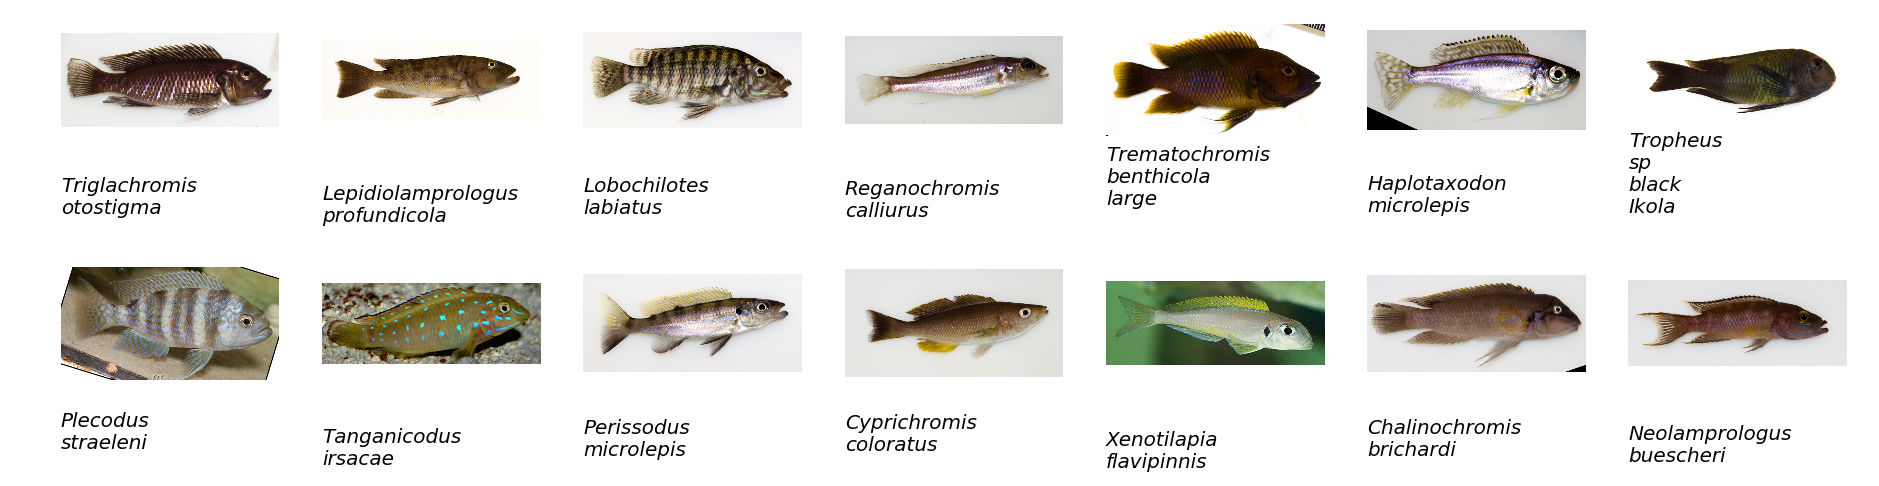

In [2]:
from IPython.display import display, Image
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(16, 4))

for root, _, files in os.walk('host_phenotypes') :
    for n,file in enumerate(files) :
        i =  mpimg.imread('host_phenotypes/' + file )
        subplot(2,7,n+1)
        plt.imshow(i)
        text( 0, 500, file.replace('_','\n').replace('.png',''), style='italic' )
        plt.axis('off')
        
#plt.tight_layout()

### Chimera detection

Here, we use [`vsearch`](https://zenodo.org/record/16153) to perform chimera detection, 
with the [SILVA SSU reference database (release 123)](http://ftp.arb-silva.de/release_123/Exports/)
as a reference database.

In [ ]:
!wget http://ftp.arb-silva.de/release_123/Exports/SILVA_123_SSURef_tax_silva_trunc.fasta.gz

In [ ]:
! vsearch --threads 48 --uchime_ref fishpoo.fasta.gz \
--db ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz    \
--chimeras fishpoo_chimeras.fasta                    \
--nonchimeras fishpoo_nochimeras.fasta

! gzip fishpoo_chimeras.fasta
! gzip fishpoo_nochimeras.fasta